In [ ]:
import torch
import gc



torch.cuda.synchronize()

gc.collect()
torch.cuda.empty_cache()




# Student Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F

class ModifiedResNet50(nn.Module):
    def __init__(self):
        super(ModifiedResNet50, self).__init__()
        self.base_model = models.resnet50(pretrained=False)
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])
        self.pool = self.base_model.avgpool
        self.fc = self.base_model.fc

    def forward(self, x):
        feature_maps = self.features(x)
        pooled_features = self.pool(feature_maps)
        flattened_features = pooled_features.view(pooled_features.size(0), -1)
        logits = self.fc(flattened_features)
        return feature_maps, logits



class PCAProjector(nn.Module):
    def __init__(self, student_channels, transformer_dim):
        super(PCAProjector, self).__init__()
        self.query = nn.Conv2d(student_channels, transformer_dim, kernel_size=3, padding=1)
        self.key = nn.Conv2d(student_channels, transformer_dim, kernel_size=3, padding=1)
        self.value = nn.Conv2d(student_channels, transformer_dim, kernel_size=3, padding=1)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attention = torch.softmax(torch.matmul(query, key.transpose(-2, -1)) / (query.size(-1) ** 0.5), dim=-1)
        return torch.matmul(attention, value)


class GLProjector(nn.Module):
    def __init__(self, student_channels, transformer_dim):
        super(GLProjector, self).__init__()
        self.fc = nn.Linear(student_channels, transformer_dim)

    def forward(self, x):
        b, c, h, w = x.size()
        x = x.permute(0, 2, 3, 1).reshape(-1, c)
        x = self.fc(x)
        return x.reshape(b, h, w, -1).permute(0, 3, 1, 2)



criterion = nn.CrossEntropyLoss()

def compute_pca_loss(teacher_features, student_features):
    return torch.nn.functional.mse_loss(teacher_features, student_features)

def compute_gl_loss(teacher_features, student_features):
    return torch.nn.functional.mse_loss(teacher_features, student_features)


import torch.nn.functional as F

def validate(model, dataloader, criterion, device='cuda'):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[1]

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = val_loss / len(dataloader)
    return avg_loss, accuracy

def train_one_epoch(dataloader, teacher_model, student_model, pca_projector, gl_projector, discriminator, optimizer):
    student_model.train()
    teacher_model.eval()
    total_loss = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            teacher_features = teacher_model(images).to(device)

        student_features, student_logits = student_model(images)

        classification_loss = criterion(student_logits, labels)

        pca_features = pca_projector(student_features)
        gl_features = gl_projector(student_features)

        b, c, h, w = pca_features.size()
        seq_len = h * w
        pca_features = pca_features.view(b, c, seq_len).permute(0, 2, 1)
        gl_features = gl_features.view(b, c, seq_len).permute(0, 2, 1)    # [Batch, Seq_Len, Channels]

        teacher_seq_len = teacher_features.size(1)
        aligned_pca_features = F.interpolate(
            pca_features.permute(0, 2, 1).to(device),
            size=teacher_seq_len,
            mode='linear',
            align_corners=False
        ).permute(0, 2, 1)  # [Batch, Seq_Len, Channels]

        aligned_gl_features = F.interpolate(
            gl_features.permute(0, 2, 1).to(device),
            size=teacher_seq_len,
            mode='linear',
            align_corners=False
        ).permute(0, 2, 1)  # [Batch, Seq_Len, Channels]


        b, seq_len, channels = aligned_pca_features.size()
        transformer_dim = teacher_features.size(-1) if teacher_features.ndim > 2 else 768
        aligned_pca_features = aligned_pca_features.reshape(-1, channels).to(device)  # [Batch * Seq_Len, Channels]
        aligned_gl_features = aligned_gl_features.reshape(-1, channels).to(device)    # [Batch * Seq_Len, Channels]

        linear_projector = nn.Linear(channels, transformer_dim).to(device)
        aligned_pca_features = linear_projector(aligned_pca_features).reshape(b, seq_len, transformer_dim).to(device)  # [Batch, Seq_Len, Transformer_Dim]
        aligned_gl_features = linear_projector(aligned_gl_features).reshape(b, seq_len, transformer_dim).to(device)    # [Batch, Seq_Len, Transformer_Dim]

        teacher_features = teacher_features.unsqueeze(-1).repeat(1, 1, aligned_pca_features.size(-1)).to(device)  # [Batch, Seq_Len, Transformer_Dim]

        pca_loss = compute_pca_loss(teacher_features, aligned_pca_features)
        gl_loss = compute_gl_loss(teacher_features, aligned_gl_features)

        total_loss = classification_loss + 0.3*(pca_loss + gl_loss)
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        total_loss += total_loss.item()

    return total_loss



# ======================== Models ========================
# Load pre-trained teacher and initialize student
teacher_model = torch.load("/content/drive/MyDrive/Tahir/grayscale_teacher_model.pth").to("cuda")
student_model = ModifiedResNet50()
student_model.fc = nn.Sequential(nn.Linear(2048, 10))
student_model = student_model.to("cuda")

device = "cuda"
batch_size = 64
optimizer = optim.SGD(student_model.parameters(), lr=0.01, momentum=0.9)

pca_projector = PCAProjector(student_channels=2048, transformer_dim=768).to(device)
gl_projector = GLProjector(student_channels=2048, transformer_dim=768).to(device)




<ipython-input-7-df766b5d6b99>:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model = torch.load("/content/drive/MyDrive/Tahir/grayscale_teacher_model.pth").to("

## CIFAR-10 normal

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

pca_projector = PCAProjector(student_channels=2048, transformer_dim=768).to(device)

gl_projector = GLProjector(student_channels=2048, transformer_dim=768).to(device)


for epoch in range(4):
    loss = train_one_epoch(dataloader, teacher_model, student_model, pca_projector, gl_projector, discriminator, optimizer)
    val_loss, val_accuracy = validate(student_model, val_dataloader, criterion, device)
    print(f"Epoch {epoch + 7}: {val_accuracy}")
    torch.save(student_model, f"/content/drive/MyDrive/Tahir/newer_student_model_epoch_{epoch + 7}.pth")


## STL-10

In [ ]:

transform_default = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
transform_occluded = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    AddOcclusion(occlusion_size=96),
])

normal_stl_10 = datasets.STL10(root='./data', split='train', download=True, transform=transform_default)
loader_stl_train = DataLoader(normal_stl_10, batch_size=64, shuffle=True)

dataset_occluded_val = datasets.STL10(root='./data', split='test', download=True, transform=transform_occluded)
loader_occluded_val = DataLoader(dataset_occluded_val, batch_size=64, shuffle=True)

pca_projector = PCAProjector(student_channels=2048, transformer_dim=768).to(device)

gl_projector = GLProjector(student_channels=2048, transformer_dim=768).to(device)

best_acc = 0
for epoch in range(10):
    loss = train_one_epoch(loader_stl_train, teacher_model, student_model, pca_projector, gl_projector, discriminator, optimizer)
    val_loss, val_accuracy = validate(student_model, loader_occluded_val, criterion, device)
    print(f"Epoch {epoch + 1}: {val_accuracy}")
    if val_accuracy > best_acc:
      best_acc = val_accuracy
      torch.save(student_model, "/content/drive/MyDrive/Tahir/stl_student_model.pth")


100%|██████████| 2.64G/2.64G [03:49<00:00, 11.5MB/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Epoch 1: 22.65
Epoch 2: 26.2625
Epoch 3: 20.3375
Epoch 4: 30.125
Epoch 5: 23.5625
Epoch 6: 34.0
Epoch 7: 33.175
Epoch 8: 32.7
Epoch 9: 36.825
Epoch 10: 27.6125


In [ ]:
best_acc = 0
for epoch in range(10):
    loss = train_one_epoch(loader_stl_train, teacher_model, student_model, pca_projector, gl_projector, discriminator, optimizer)
    val_loss, val_accuracy = validate(student_model, loader_occluded_val, criterion, device)
    print(f"Epoch {epoch + 1}: {val_accuracy}")
    if val_accuracy > best_acc:
      best_acc = val_accuracy
      torch.save(student_model, "/content/drive/MyDrive/Tahir/control_stl_student_model.pth")

Epoch 1: 20.5
Epoch 2: 21.6375
Epoch 3: 26.425
Epoch 4: 25.1375
Epoch 5: 27.45
Epoch 6: 26.0875
Epoch 7: 31.45
Epoch 8: 27.6125
Epoch 9: 33.0375
Epoch 10: 23.475


## FMNIST-background


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image, ImageOps, ImageDraw

def add_background(image, texture_type='noise'):
    if image.ndimension() == 3 and image.size(0) == 3:
        image = image.permute(1, 2, 0).numpy()
    elif image.ndimension() == 3 and image.size(0) == 1:
        image = image.squeeze(0).numpy()
    else:
        raise ValueError(f"Unexpected input dimensions: {image.shape}")

    image = Image.fromarray(np.uint8(image * 255))

    if texture_type == 'noise':
        noise = np.random.randint(0, 255, (image.height, image.width, 3), dtype=np.uint8)
        background = Image.fromarray(noise)
    else:
        background = Image.new("RGB", image.size, "white")

    combined = Image.blend(background, image.convert("RGB"), alpha=0.7)
    return transforms.ToTensor()(combined)





class FashionMNISTCustom(datasets.FashionMNIST):
    def __init__(self, *args, augmentation=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.augmentation = augmentation

    def __getitem__(self, index):
        image, label = super().__getitem__(index)

        if self.augmentation:
            if self.augmentation == 'background':
                image = add_background(image, texture_type='noise')
            elif self.augmentation == 'scale':
                scale_factor = np.random.uniform(0.5, 1.5)

        return image, label

transform_default = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset_default = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_default)
loader_default = DataLoader(dataset_default, batch_size=64, shuffle=True)

dataset_with_bg = FashionMNISTCustom(root='./data', train=False, download=True, augmentation='background', transform=transform_default)
loader_with_bg = DataLoader(dataset_with_bg, batch_size=64, shuffle=True)

In [ ]:
best_acc = 0
for epoch in range(10):
    loss = train_one_epoch(loader_default, teacher_model, student_model, pca_projector, gl_projector, discriminator, optimizer)
    val_loss, val_accuracy = validate(student_model, loader_with_bg, criterion, device)
    print(f"Epoch {epoch + 1}: {val_accuracy}")
    if val_accuracy > best_acc:
      best_acc = val_accuracy
      torch.save(student_model, "/content/drive/MyDrive/Tahir/control_fmnist_bg_student_model.pth")

Epoch 1: 12.88
Epoch 2: 10.02
Epoch 3: 10.0
Epoch 4: 10.55
Epoch 5: 12.74
Epoch 6: 13.33
Epoch 7: 13.43
Epoch 8: 21.51
Epoch 9: 13.21
Epoch 10: 18.03


In [ ]:


best_acc = 0
for epoch in range(10):
    loss = train_one_epoch(loader_default, teacher_model, student_model, pca_projector, gl_projector, discriminator, optimizer)
    val_loss, val_accuracy = validate(student_model, loader_with_bg, criterion, device)
    print(f"Epoch {epoch + 1}: {val_accuracy}")
    if val_accuracy > best_acc:
      best_acc = val_accuracy
      torch.save(student_model, "/content/drive/MyDrive/Tahir/fmnist_bg_student_model.pth")

Epoch 1: 11.01
Epoch 2: 10.01
Epoch 3: 28.51
Epoch 4: 15.96
Epoch 5: 18.82
Epoch 6: 19.29
Epoch 7: 22.83
Epoch 8: 32.49
Epoch 9: 17.4
Epoch 10: 20.33


## dsprites

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Subset

dsprites_path = '/content/drive/MyDrive/Tahir/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
data = np.load(dsprites_path, allow_pickle=True)

images = data['imgs']
metadata = data['latents_classes']

LATENT_NAMES = ['color', 'shape', 'scale', 'orientation', 'posX', 'posY']
SHAPES = ['square', 'ellipse', 'heart']

class dSpritesDataset(Dataset):
    def __init__(self, images, metadata, target_shape=None, restrict_position=None):
        self.images = images
        self.metadata = metadata

        if target_shape is not None:
            shape_idx = SHAPES.index(target_shape)
            valid_idx = self.metadata[:, 1] == shape_idx
            self.metadata = self.metadata[valid_idx]
            self.images = self.images[valid_idx]

        if restrict_position is not None:
            x_min, x_max, y_min, y_max = restrict_position

            posX_normalized = self.metadata[:, 4] / (images.shape[1] - 1)
            posY_normalized = self.metadata[:, 5] / (images.shape[2] - 1)

            valid_idx = (posX_normalized >= x_min) & (posX_normalized <= x_max) & \
                        (posY_normalized >= y_min) & (posY_normalized <= y_max)
            self.metadata = self.metadata[valid_idx]
            self.images = self.images[valid_idx]

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.metadata[idx]

        image = np.expand_dims(image, axis=0)  # Shape: [1, Height, Width]

        image = np.repeat(image, 3, axis=0) * 255  # Scale to [0, 255] for visualization

        image = self.transform(image.transpose(1, 2, 0).astype(np.uint8))

        shape_label = label[1]  # (square, ellipse, heart)

        return image, int(shape_label)



dataset_square = dSpritesDataset(images, metadata, target_shape='square')
dataset_ellipse = dSpritesDataset(images, metadata, target_shape='ellipse')
dataset_position_restricted = dSpritesDataset(images, metadata, target_shape= 'square',restrict_position=(0.2, 0.8, 0.2, 0.8))

batch_size = 64
max_samples = 20000
indices_square = np.random.permutation(len(dataset_square))[:max_samples]
indices_ellipse = np.random.permutation(len(dataset_ellipse))[:max_samples]
indices_position_restricted = np.random.permutation(len(dataset_position_restricted))[:max_samples]

dataset_square_subset = Subset(dataset_square, indices_square)
dataset_ellipse_subset = Subset(dataset_ellipse, indices_ellipse)
dataset_position_restricted_subset = Subset(dataset_position_restricted, indices_position_restricted)

loader_square = DataLoader(dataset_square_subset, batch_size=batch_size, shuffle=True)
loader_ellipse = DataLoader(dataset_ellipse_subset, batch_size=batch_size, shuffle=True)
loader_position_restricted = DataLoader(dataset_position_restricted_subset, batch_size=batch_size, shuffle=True)

print("Datasets prepared (subsets):")
print(f"Square shapes subset: {len(dataset_square_subset)} samples")
print(f"Ellipse shapes subset: {len(dataset_ellipse_subset)} samples")
print(f"Restricted position subset: {len(dataset_position_restricted_subset)} samples")



Datasets prepared (subsets):
Square shapes subset: 20000 samples
Ellipse shapes subset: 20000 samples
Restricted position subset: 20000 samples


## CIFAR-10 Color Jittered

In [ ]:
color_jitter_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.ToTensor()
])
cifar10_color_jitter_val = datasets.CIFAR10(root='./data', train=False, download=True, transform=color_jitter_transform)
loader_color_jitter_val = DataLoader(cifar10_color_jitter_val, batch_size=batch_size, shuffle=True)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

pca_projector = PCAProjector(student_channels=2048, transformer_dim=768).to(device)

gl_projector = GLProjector(student_channels=2048, transformer_dim=768).to(device)


for epoch in range(10):
    loss = train_one_epoch(dataloader, teacher_model, student_model, pca_projector, gl_projector, discriminator, optimizer)
    val_loss, val_accuracy = validate(student_model, loader_color_jitter_val, criterion, device)
    print(f"Epoch {epoch + 7}: {val_accuracy}")
    torch.save(student_model, f"/content/drive/MyDrive/Tahir/color_jitter_student_cifar.pth")



Files already downloaded and verified
Files already downloaded and verified
Epoch 7: 28.7
Epoch 8: 41.58
Epoch 9: 54.58
Epoch 10: 57.27
Epoch 11: 64.81
Epoch 12: 64.9
Epoch 13: 67.35
Epoch 14: 62.88
Epoch 15: 66.55
Epoch 16: 69.02


In [ ]:
color_jitter_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.ToTensor()
])

cifar10_color_jitter_val = datasets.CIFAR10(root='./data', train=False, download=True, transform=color_jitter_transform)
loader_color_jitter_val = DataLoader(cifar10_color_jitter_val, batch_size=batch_size, shuffle=True)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

pca_projector = PCAProjector(student_channels=2048, transformer_dim=768).to(device)

gl_projector = GLProjector(student_channels=2048, transformer_dim=768).to(device)


for epoch in range(10):
    loss = train_one_epoch(dataloader, teacher_model, student_model, pca_projector, gl_projector, discriminator, optimizer)
    val_loss, val_accuracy = validate(student_model, loader_color_jitter_val, criterion, device)
    print(f"Epoch {epoch + 1}: {val_accuracy}")
    torch.save(student_model, f"/content/drive/MyDrive/Tahir/control_color_jitter_student_cifar.pth")



100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: 29.75
Epoch 2: 42.92
Epoch 3: 55.02
Epoch 4: 59.16
Epoch 5: 63.14
Epoch 6: 62.83
Epoch 7: 66.08
Epoch 8: 68.54
Epoch 9: 69.23
Epoch 10: 68.52


## GrayScale

In [ ]:
grayscale_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

cifar10_grayscale_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_grayscale_val = datasets.CIFAR10(root='./data', train=False, download=True, transform=grayscale_transform)

loader_grayscale_train = DataLoader(cifar10_grayscale_train, batch_size=batch_size, shuffle=True)
loader_grayscale_val = DataLoader(cifar10_grayscale_val, batch_size=batch_size, shuffle=True)

pca_projector = PCAProjector(student_channels=2048, transformer_dim=768).to(device)

gl_projector = GLProjector(student_channels=2048, transformer_dim=768).to(device)


for epoch in range(10):
    loss = train_one_epoch(loader_grayscale_train, teacher_model, student_model, pca_projector, gl_projector, discriminator, optimizer)
    val_loss, val_accuracy = validate(student_model, loader_grayscale_val, criterion, device)
    print(f"Epoch {epoch + 7}: {val_accuracy}")
    torch.save(student_model, f"/content/drive/MyDrive/Tahir/grayscale_student_cifar.pth")

Files already downloaded and verified
Files already downloaded and verified
Epoch 7: 42.19
Epoch 8: 55.88
Epoch 9: 58.79
Epoch 10: 66.92
Epoch 11: 68.21
Epoch 12: 69.45
Epoch 13: 71.96
Epoch 14: 64.63
Epoch 15: 69.32
Epoch 16: 72.5


In [ ]:
grayscale_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

cifar10_grayscale_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_grayscale_val = datasets.CIFAR10(root='./data', train=False, download=True, transform=grayscale_transform)

loader_grayscale_train = DataLoader(cifar10_grayscale_train, batch_size=batch_size, shuffle=True)
loader_grayscale_val = DataLoader(cifar10_grayscale_val, batch_size=batch_size, shuffle=True)

pca_projector = PCAProjector(student_channels=2048, transformer_dim=768).to(device)

gl_projector = GLProjector(student_channels=2048, transformer_dim=768).to(device)


for epoch in range(10):
    loss = train_one_epoch(loader_grayscale_train, teacher_model, student_model, pca_projector, gl_projector, discriminator, optimizer)
    val_loss, val_accuracy = validate(student_model, loader_grayscale_val, criterion, device)
    print(f"Epoch {epoch + 7}: {val_accuracy}")
    torch.save(student_model, f"/content/drive/MyDrive/Tahir/control_grayscale_student_cifar.pth")

Files already downloaded and verified
Files already downloaded and verified
Epoch 7: 33.75
Epoch 8: 48.09
Epoch 9: 56.36
Epoch 10: 65.63
Epoch 11: 71.74
Epoch 12: 68.58
Epoch 13: 72.76
Epoch 14: 67.94
Epoch 15: 69.69
Epoch 16: 71.45


In [ ]:
from google.colab import runtime
runtime.unassign()


# Teacher Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torchvision.models as models

teacher_model = models.vit_b_16(pretrained=True)

for param in teacher_model.parameters():
    param.requires_grad = False

teacher_model.heads = nn.Sequential(
    nn.Linear(teacher_model.heads[0].in_features, 10)
)
for param in teacher_model.heads.parameters():
    param.requires_grad = True

teacher_model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(teacher_model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
device = 'cuda'
num_epochs = 10
batch_size = 64

def train_one_epoch(model, dataloader, criterion, optimizer, device='cuda'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

def validate(model, dataloader, criterion, device='cuda'):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = val_loss / len(dataloader)
    return avg_loss, accuracy



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 208MB/s]


## CIFAR-10 nomral

In [ ]:


transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

device = 'cuda'
num_epochs = 10

best_acc = 0
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(teacher_model, train_dataloader, criterion, optimizer, device)

    val_loss, val_accuracy = validate(teacher_model, val_dataloader, criterion, device)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    if best_acc < val_accuracy:
      best_acc = val_accuracy
      torch.save(teacher_model,f"/content/drive/MyDrive/Tahir/teacher_model_{epoch}.pth")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10: Train Loss: 0.8913, Train Accuracy: 80.10% | Val Loss: 0.4750, Val Accuracy: 87.47%
Epoch 2/10: Train Loss: 0.4038, Train Accuracy: 88.82% | Val Loss: 0.3665, Val Accuracy: 89.10%
Epoch 3/10: Train Loss: 0.3368, Train Accuracy: 89.76% | Val Loss: 0.3278, Val Accuracy: 89.85%
Epoch 4/10: Train Loss: 0.3061, Train Accuracy: 90.39% | Val Loss: 0.3064, Val Accuracy: 90.38%
Epoch 5/10: Train Loss: 0.2876, Train Accuracy: 90.80% | Val Loss: 0.2933, Val Accuracy: 90.59%
Epoch 6/10: Train Loss: 0.2742, Train Accuracy: 91.18% | Val Loss: 0.2835, Val Accuracy: 90.99%
Epoch 7/10: Train Loss: 0.2638, Train Accuracy: 91.48% | Val Loss: 0.2760, Val Accuracy: 91.17%
Epoch 8/10: Train Loss: 0.2555, Train Accuracy: 91.69% | Val Loss: 0.2702, Val Accuracy: 91.31%
Epoch 9/10: Train Loss: 0.2486, Train Accuracy: 91.90% | Val Loss: 0.2652, Val Accuracy: 91.61%
Epoch 10/10: Train Loss: 0.2428, Train Accuracy: 92.06% | Va

## CIFAR-10 Color jittered

In [ ]:
color_jitter_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.ToTensor()
])
cifar10_color_jitter_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=color_jitter_transform)
cifar10_color_jitter_val = datasets.CIFAR10(root='./data', train=False, download=True, transform=color_jitter_transform)

loader_color_jitter_train = DataLoader(cifar10_color_jitter_train, batch_size=batch_size, shuffle=True)
loader_color_jitter_val = DataLoader(cifar10_color_jitter_val, batch_size=batch_size, shuffle=True)

best_acc = 0
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(teacher_model, loader_color_jitter_train, criterion, optimizer, device)

    val_loss, val_accuracy = validate(teacher_model, loader_color_jitter_val, criterion, device)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    if best_acc < val_accuracy:
      best_acc = val_accuracy
      torch.save(teacher_model,f"/content/drive/MyDrive/Tahir/color_teacher_model_{epoch}.pth")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10: Train Loss: 1.0788, Train Accuracy: 72.68% | Val Loss: 0.7025, Val Accuracy: 79.93%
Epoch 2/10: Train Loss: 0.6179, Train Accuracy: 81.66% | Val Loss: 0.5760, Val Accuracy: 82.25%
Epoch 3/10: Train Loss: 0.5375, Train Accuracy: 83.11% | Val Loss: 0.5307, Val Accuracy: 82.70%
Epoch 4/10: Train Loss: 0.4965, Train Accuracy: 84.14% | Val Loss: 0.4900, Val Accuracy: 83.96%
Epoch 5/10: Train Loss: 0.4722, Train Accuracy: 84.66% | Val Loss: 0.4744, Val Accuracy: 84.42%
Epoch 6/10: Train Loss: 0.4558, Train Accuracy: 85.08% | Val Loss: 0.4609, Val Accuracy: 84.85%
Epoch 7/10: Train Loss: 0.4435, Train Accuracy: 85.55% | Val Loss: 0.4537, Val Accuracy: 85.00%
Epoch 8/10: Train Loss: 0.4283, Train Accuracy: 86.02% | Val Loss: 0.4406, Val Accuracy: 85.29%
Epoch 9/10: Train Loss: 0.4215, Train Accuracy: 86.13% | Val Loss: 0.4359, Val Accuracy: 85.34%
Epoch 10/10: Train Loss: 0.4205, Train Accuracy: 86.29% | Va

## CIFAR-10 GrayScale

In [ ]:
grayscale_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

cifar10_grayscale_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=grayscale_transform)
cifar10_grayscale_val = datasets.CIFAR10(root='./data', train=False, download=True, transform=grayscale_transform)

loader_grayscale_train = DataLoader(cifar10_grayscale_train, batch_size=batch_size, shuffle=True)
loader_grayscale_val = DataLoader(cifar10_color_jitter_val, batch_size=batch_size, shuffle=True)

best_acc = 0
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(teacher_model, loader_grayscale_train, criterion, optimizer, device)

    val_loss, val_accuracy = validate(teacher_model, loader_grayscale_val, criterion, device)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    if best_acc < val_accuracy:
      best_acc = val_accuracy
      torch.save(teacher_model,f"/content/drive/MyDrive/Tahir/grayscale_teacher_model.pth")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10: Train Loss: 1.1335, Train Accuracy: 67.43% | Val Loss: 0.8670, Val Accuracy: 74.33%
Epoch 2/10: Train Loss: 0.7080, Train Accuracy: 77.27% | Val Loss: 0.7124, Val Accuracy: 78.02%
Epoch 3/10: Train Loss: 0.6295, Train Accuracy: 79.27% | Val Loss: 0.6538, Val Accuracy: 79.25%
Epoch 4/10: Train Loss: 0.5891, Train Accuracy: 80.32% | Val Loss: 0.6144, Val Accuracy: 80.25%
Epoch 5/10: Train Loss: 0.5627, Train Accuracy: 81.13% | Val Loss: 0.6216, Val Accuracy: 80.02%
Epoch 6/10: Train Loss: 0.5444, Train Accuracy: 81.72% | Val Loss: 0.5881, Val Accuracy: 80.68%
Epoch 7/10: Train Loss: 0.5300, Train Accuracy: 82.18% | Val Loss: 0.5739, Val Accuracy: 80.92%
Epoch 8/10: Train Loss: 0.5183, Train Accuracy: 82.60% | Val Loss: 0.5696, Val Accuracy: 81.31%
Epoch 9/10: Train Loss: 0.5089, Train Accuracy: 82.81% | Val Loss: 0.5675, Val Accuracy: 81.35%
Epoch 10/10: Train Loss: 0.5005, Train Accuracy: 83.06% | Va

## STL-10

In [ ]:
import random
from PIL import Image
import torchvision.transforms.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class AddOcclusion:
    def __init__(self, occlusion_size=16):
        self.occlusion_size = occlusion_size

    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = F.to_tensor(img)

        if len(img.shape) != 3:
            raise TypeError(f"Expected tensor with 3 dimensions (C, H, W). Got {img.shape}")

        _, h, w = img.shape
        x_start = random.randint(0, w - self.occlusion_size)
        y_start = random.randint(0, h - self.occlusion_size)

        img[:, y_start:y_start + self.occlusion_size, x_start:x_start + self.occlusion_size] = 0
        return img


transform_occluded = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    AddOcclusion(occlusion_size=96),
])

dataset_occluded_train = datasets.STL10(root='./data', split='train', download=True, transform=transform_occluded)
dataset_occluded_val = datasets.STL10(root='./data', split='test', download=True, transform=transform_occluded)
loader_occluded_train = DataLoader(dataset_occluded_train, batch_size=64, shuffle=True)
loader_occluded_val = DataLoader(dataset_occluded_val, batch_size=64, shuffle=True)


Displaying occluded images:


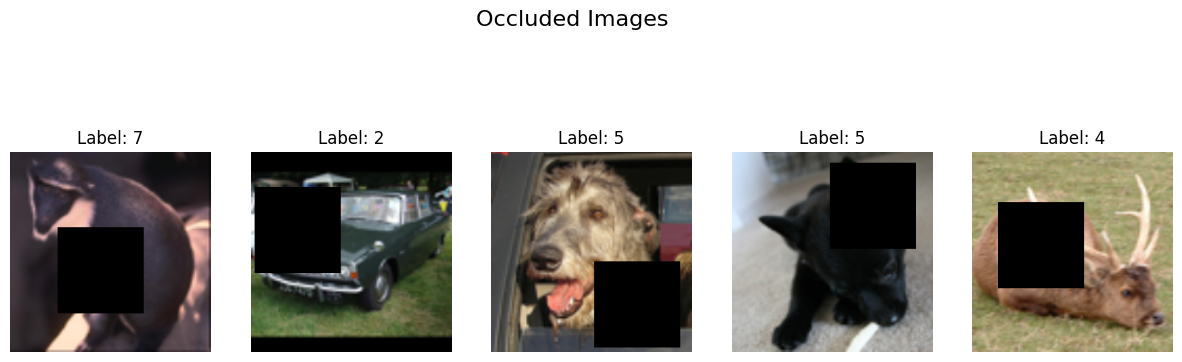

In [ ]:
def display_occluded_images(loader, title, num_images=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {labels[i].item()}")
    plt.show()

print("Displaying occluded images:")
display_occluded_images(loader_occluded_train, "Occluded Images")



In [ ]:
best_acc = 0
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(teacher_model, loader_occluded_train, criterion, optimizer, device)

    val_loss, val_accuracy = validate(teacher_model, loader_occluded_val, criterion, device)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    if best_acc < val_accuracy:
      best_acc = val_accuracy
      torch.save(teacher_model,f"/content/drive/MyDrive/Tahir/stl_teacher_model.pth")

Epoch 1/10: Train Loss: 1.9970, Train Accuracy: 43.44% | Val Loss: 1.6551, Val Accuracy: 77.46%
Epoch 2/10: Train Loss: 1.3929, Train Accuracy: 85.26% | Val Loss: 1.1637, Val Accuracy: 90.21%
Epoch 3/10: Train Loss: 0.9964, Train Accuracy: 91.30% | Val Loss: 0.8595, Val Accuracy: 92.53%
Epoch 4/10: Train Loss: 0.7479, Train Accuracy: 93.08% | Val Loss: 0.6702, Val Accuracy: 93.70%
Epoch 5/10: Train Loss: 0.5981, Train Accuracy: 94.00% | Val Loss: 0.5468, Val Accuracy: 93.85%
Epoch 6/10: Train Loss: 0.4971, Train Accuracy: 94.00% | Val Loss: 0.4650, Val Accuracy: 94.38%
Epoch 7/10: Train Loss: 0.4250, Train Accuracy: 94.54% | Val Loss: 0.4034, Val Accuracy: 94.50%
Epoch 8/10: Train Loss: 0.3796, Train Accuracy: 94.76% | Val Loss: 0.3654, Val Accuracy: 94.56%
Epoch 9/10: Train Loss: 0.3431, Train Accuracy: 94.70% | Val Loss: 0.3302, Val Accuracy: 94.59%
Epoch 10/10: Train Loss: 0.3038, Train Accuracy: 95.14% | Val Loss: 0.3018, Val Accuracy: 95.16%


## FMNIST-background

In [ ]:
best_acc = 0
for epoch in range(10):
    train_loss, train_accuracy = train_one_epoch(teacher_model, loader_with_bg, criterion, optimizer, device)

    val_loss, val_accuracy = validate(teacher_model, loader_with_bg, criterion, device)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    if best_acc < val_accuracy:
      best_acc = val_accuracy
      torch.save(teacher_model,f"/content/drive/MyDrive/Tahir/fmnist_teacher_model.pth")

Epoch 1/10: Train Loss: 1.6552, Train Accuracy: 55.19% | Val Loss: 1.1911, Val Accuracy: 72.38%
Epoch 2/10: Train Loss: 0.9973, Train Accuracy: 74.96% | Val Loss: 0.8514, Val Accuracy: 78.12%
Epoch 3/10: Train Loss: 0.7745, Train Accuracy: 78.56% | Val Loss: 0.7145, Val Accuracy: 79.21%
Epoch 4/10: Train Loss: 0.6759, Train Accuracy: 79.64% | Val Loss: 0.6426, Val Accuracy: 80.27%
Epoch 5/10: Train Loss: 0.6205, Train Accuracy: 80.72% | Val Loss: 0.5967, Val Accuracy: 81.15%
Epoch 6/10: Train Loss: 0.5825, Train Accuracy: 81.27% | Val Loss: 0.5646, Val Accuracy: 81.49%
Epoch 7/10: Train Loss: 0.5519, Train Accuracy: 82.07% | Val Loss: 0.5403, Val Accuracy: 82.31%
Epoch 8/10: Train Loss: 0.5332, Train Accuracy: 82.18% | Val Loss: 0.5222, Val Accuracy: 82.38%
Epoch 9/10: Train Loss: 0.5147, Train Accuracy: 82.80% | Val Loss: 0.5035, Val Accuracy: 82.89%
Epoch 10/10: Train Loss: 0.5029, Train Accuracy: 82.76% | Val Loss: 0.4936, Val Accuracy: 83.31%


# CNN teacher

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image, ImageOps, ImageDraw

def add_background(image, texture_type='noise'):
    if image.ndimension() == 3 and image.size(0) == 3:
        image = image.permute(1, 2, 0).numpy()
    elif image.ndimension() == 3 and image.size(0) == 1:
        image = image.squeeze(0).numpy()
    else:
        raise ValueError(f"Unexpected input dimensions: {image.shape}")

    image = Image.fromarray(np.uint8(image * 255))

    if texture_type == 'noise':
        noise = np.random.randint(0, 255, (image.height, image.width, 3), dtype=np.uint8)
        background = Image.fromarray(noise)
    else:
        background = Image.new("RGB", image.size, "white")

    combined = Image.blend(background, image.convert("RGB"), alpha=0.7)
    return transforms.ToTensor()(combined)





class FashionMNISTCustom(datasets.FashionMNIST):
    def __init__(self, *args, augmentation=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.augmentation = augmentation

    def __getitem__(self, index):
        image, label = super().__getitem__(index)

        if self.augmentation:
            if self.augmentation == 'background':
                image = add_background(image, texture_type='noise')
            elif self.augmentation == 'scale':
                scale_factor = np.random.uniform(0.5, 1.5)

        return image, label

transform_default = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# dataset_default = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_default)
# loader_default = DataLoader(dataset_default, batch_size=64, shuffle=True)

dataset_with_bg = FashionMNISTCustom(root='./data', train=True, download=True, transform=transform_default)
train_loader = DataLoader(dataset_with_bg, batch_size=64, shuffle=True)

test_dataset = FashionMNISTCustom(root='./data', train=False, download=True, augmentation='background', transform=transform_default)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]


Extracting ./data/FashionMNISTCustom/raw/train-images-idx3-ubyte.gz to ./data/FashionMNISTCustom/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 167kB/s]


Extracting ./data/FashionMNISTCustom/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNISTCustom/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.11MB/s]


Extracting ./data/FashionMNISTCustom/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNISTCustom/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.25MB/s]

Extracting ./data/FashionMNISTCustom/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNISTCustom/raw



## teacher

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models



resnet101 =   models.wide_resnet101_2(pretrained=True)
num_classes = 10
in_features = resnet101.fc.in_features

resnet101.fc = nn.Linear(in_features, num_classes)

for param in resnet101.parameters():
    param.requires_grad = False

for param in resnet101.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet101 = resnet101.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet101.parameters(), lr=0.001)

def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), correct / total * 100

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total * 100

best_acc= 0
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train(resnet101, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(resnet101, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    if best_acc < val_acc:
      best_acc = val_acc
      torch.save(resnet101,"/content/drive/MyDrive/Tahir/resnet_teacher_fmnist")

Epoch 1/10 -> Train Loss: 0.9312, Train Acc: 68.65% | Val Loss: 0.7663, Val Acc: 72.53%
Epoch 2/10 -> Train Loss: 0.7435, Train Acc: 73.39% | Val Loss: 0.7207, Val Acc: 74.72%
Epoch 3/10 -> Train Loss: 0.7153, Train Acc: 74.31% | Val Loss: 0.6867, Val Acc: 75.09%
Epoch 4/10 -> Train Loss: 0.7034, Train Acc: 74.71% | Val Loss: 0.6983, Val Acc: 74.61%
Epoch 5/10 -> Train Loss: 0.6918, Train Acc: 74.89% | Val Loss: 0.6972, Val Acc: 74.60%
Epoch 6/10 -> Train Loss: 0.6834, Train Acc: 75.27% | Val Loss: 0.6847, Val Acc: 75.55%
Epoch 7/10 -> Train Loss: 0.6776, Train Acc: 75.34% | Val Loss: 0.6651, Val Acc: 76.19%
Epoch 8/10 -> Train Loss: 0.6751, Train Acc: 75.54% | Val Loss: 0.6921, Val Acc: 75.02%
Epoch 9/10 -> Train Loss: 0.6713, Train Acc: 75.72% | Val Loss: 0.6546, Val Acc: 76.28%
Epoch 10/10 -> Train Loss: 0.6663, Train Acc: 75.82% | Val Loss: 0.6701, Val Acc: 76.21%


## student

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
learning_rate = 0.01
num_epochs = 10
hint_layer_student = "layer3"
hint_layer_teacher = "layer4"


teacher_model = torch.load("/content/drive/MyDrive/Tahir/resnet_teacher_fmnist").to(device)
student_model = torch.load()
for param in teacher_model.parameters():
    param.requires_grad = False


class HintLoss(nn.Module):
    def __init__(self, teacher_dim, student_dim):
        super(HintLoss, self).__init__()
        self.criterion = nn.MSELoss()
        self.adaptive_pool_teacher = nn.AdaptiveAvgPool2d((1, 1))  # Pool to [B, C, 1, 1]
        self.adaptive_pool_student = nn.AdaptiveAvgPool2d((1, 1))  # Pool to [B, C, 1, 1]
        self.teacher_fc = nn.Linear(teacher_dim, student_dim)

    def forward(self, student_features, teacher_features):
        teacher_features = self.adaptive_pool_teacher(teacher_features)  # [B, C, 1, 1]
        student_features = self.adaptive_pool_student(student_features)  # [B, C, 1, 1]

        teacher_features = teacher_features.view(teacher_features.size(0), -1)  # [B, C]
        student_features = student_features.view(student_features.size(0), -1)  # [B, C]

        teacher_features = self.teacher_fc(teacher_features)  # [B, student_dim]

        return self.criterion(student_features, teacher_features)




class FeatureExtractor:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.features = None
        self.hook = None
        self.register_hook()

    def hook_fn(self, module, input, output):
        self.features = output

    def register_hook(self):
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                self.hook = module.register_forward_hook(self.hook_fn)

    def remove_hook(self):
        if self.hook:
            self.hook.remove()

teacher_extractor = FeatureExtractor(teacher_model, hint_layer_teacher)
student_extractor = FeatureExtractor(student_model, hint_layer_student)

optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)
teacher_dim = 2048
student_dim = 1024

hint_loss_fn = HintLoss(teacher_dim=teacher_dim, student_dim=student_dim).to(device)

classification_loss_fn = nn.CrossEntropyLoss()

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    accuracy = 100.0 * correct / total
    return val_loss / len(val_loader), accuracy


best_acc = 0
for epoch in range(num_epochs):
    student_model.train()
    teacher_model.eval()

    epoch_loss = 0
    epoch_hint_loss = 0
    epoch_class_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        teacher_outputs = teacher_model(images)
        student_outputs = student_model(images)

        teacher_features = teacher_extractor.features
        student_features = student_extractor.features
        hint_loss = hint_loss_fn(student_features, teacher_features)

        classification_loss = classification_loss_fn(student_outputs, labels)

        total_loss = classification_loss + 0.3 * hint_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        epoch_hint_loss += hint_loss.item()
        epoch_class_loss += classification_loss.item()

    val_loss, val_acc = validate(student_model, test_loader, classification_loss_fn, device)

    print(f"Epoch {epoch + 1}/{num_epochs}: Total Loss={epoch_loss:.4f}, Hint Loss={epoch_hint_loss:.4f}, "
          f"Classification Loss={epoch_class_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

    if best_acc < val_acc:
        best_acc = val_acc
        torch.save(student_model, "/content/drive/MyDrive/Tahir/resnet_student_fmnist")

teacher_extractor.remove_hook()
student_extractor.remove_hook()




<ipython-input-2-e0d10fbbc232>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model = torch.load("/content/drive/MyDrive/Tahir/resnet_teacher_fmnist").to(device)


Epoch 1/10: Total Loss=817316.8224, Hint Loss=2721044.5073, Classification Loss=1003.4371, Val Loss=3.9304, Val Acc=19.12%
Epoch 2/10: Total Loss=609289.0671, Hint Loss=2029173.5356, Classification Loss=536.9830, Val Loss=1.3416, Val Acc=53.71%
Epoch 3/10: Total Loss=577069.1238, Hint Loss=1922191.4827, Classification Loss=411.6567, Val Loss=2.4564, Val Acc=31.19%
Epoch 4/10: Total Loss=571723.1483, Hint Loss=1904573.5649, Classification Loss=351.0551, Val Loss=1.5701, Val Acc=49.62%
Epoch 5/10: Total Loss=569859.7123, Hint Loss=1898489.5277, Classification Loss=312.8299, Val Loss=1.7168, Val Acc=45.93%
Epoch 6/10: Total Loss=569069.2732, Hint Loss=1895926.1434, Classification Loss=291.4078, Val Loss=1.6236, Val Acc=50.56%
Epoch 7/10: Total Loss=568458.3844, Hint Loss=1893967.3154, Classification Loss=268.1672, Val Loss=1.9587, Val Acc=45.09%
Epoch 8/10: Total Loss=567969.5291, Hint Loss=1892402.8785, Classification Loss=248.6445, Val Loss=1.8338, Val Acc=48.12%
Epoch 9/10: Total Loss=